In [1]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import torch, time

from sklearn.metrics import mean_squared_error
import h5py

import neuravi
import os


# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
      
device = 'cpu'
print(device)

import neuravi

CUDA AVAILABLE?  True
cpu


# Data import

In [2]:
path_data = "./data/DataSet_0p20val.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"

ds = neuravi.data_loader(path_data,path_raman,path_density,path_optical,device)

/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


# Architecture experiment results

In [3]:
# List of networks
list_models = os.listdir("./model/exp_arch/")
nb_exp = len(list_models)

record_loss = pd.DataFrame()

record_loss["name"] = list_models

record_loss["nb_layers"] = np.zeros(nb_exp)
record_loss["nb_neurons"] = np.zeros(nb_exp)
record_loss["p_drop"] = np.zeros(nb_exp)

record_loss["loss_ag_train"] = np.zeros(nb_exp)
record_loss["loss_ag_valid"] = np.zeros(nb_exp)
record_loss["loss_ag_test"] = np.zeros(nb_exp)

record_loss["loss_am_train"] = np.zeros(nb_exp)
record_loss["loss_am_valid"] = np.zeros(nb_exp)
record_loss["loss_am_test"] = np.zeros(nb_exp)

record_loss["loss_am_train"] = np.zeros(nb_exp)
record_loss["loss_am_valid"] = np.zeros(nb_exp)
record_loss["loss_am_test"] = np.zeros(nb_exp)

record_loss["loss_Sconf_train"] = np.zeros(nb_exp)
record_loss["loss_Sconf_valid"] = np.zeros(nb_exp)
record_loss["loss_Sconf_test"] = np.zeros(nb_exp)

record_loss["loss_d_train"] = np.zeros(nb_exp)
record_loss["loss_d_valid"] = np.zeros(nb_exp)
record_loss["loss_d_test"] = np.zeros(nb_exp)

record_loss["loss_raman_train"] = np.zeros(nb_exp)
record_loss["loss_raman_valid"] = np.zeros(nb_exp)

record_loss["loss_valid"] = np.zeros(nb_exp)
record_loss["loss_test"] = np.zeros(nb_exp)

# Loss criterion
criterion = torch.nn.MSELoss()

# Load dataset
for idx,name in enumerate(list_models):
    
    # Extract arch
    nb_layers = int(name[name.find("l")+1:name.find("_")])
    nb_neurons = int(name[name.find("n")+1:name.rfind("_")])
    p_drop = float(name[name.find("p")+1:name.rfind(".")])
    
    # Record arch
    record_loss.loc[idx,"nb_layers"] = nb_layers
    record_loss.loc[idx,"nb_neurons"] = nb_neurons
    record_loss.loc[idx,"p_drop"] = p_drop
    
    # Declare model
    neuralmodel = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
    neuralmodel.load_state_dict(torch.load("./model/exp_arch/"+name, map_location='cpu'))
    neuralmodel.eval()
    
    # PREDICTIONS
    
    # train
    y_ag_pred_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
    y_myega_pred_train = neuralmodel.myega(ds.x_visco_train,ds.T_visco_train)
    y_am_pred_train = neuralmodel.am(ds.x_visco_train,ds.T_visco_train)
    y_raman_pred_train = neuralmodel.raman_pred(ds.x_raman_train)
    y_density_pred_train = neuralmodel.density(ds.x_density_train)
    y_entro_pred_train = neuralmodel.sctg(ds.x_entro_train)
    y_ri_pred_train = neuralmodel.sellmeier(ds.x_ri_train, ds.lbd_ri_train)

    # valid
    y_ag_pred_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)
    y_myega_pred_valid = neuralmodel.myega(ds.x_visco_valid,ds.T_visco_valid)
    y_am_pred_valid = neuralmodel.am(ds.x_visco_valid,ds.T_visco_valid)
    y_raman_pred_valid = neuralmodel.raman_pred(ds.x_raman_valid)
    y_density_pred_valid = neuralmodel.density(ds.x_density_valid)
    y_entro_pred_valid = neuralmodel.sctg(ds.x_entro_valid)
    y_ri_pred_valid = neuralmodel.sellmeier(ds.x_ri_valid, ds.lbd_ri_valid)
    
    # test
    y_ag_pred_test = neuralmodel.ag(ds.x_visco_test,ds.T_visco_test)
    y_myega_pred_test = neuralmodel.myega(ds.x_visco_test,ds.T_visco_test)
    y_am_pred_test = neuralmodel.am(ds.x_visco_test,ds.T_visco_test)
    #y_raman_pred_test = neuralmodel.raman_pred(x_raman_test) # Raman has no test set yet
    y_density_pred_test = neuralmodel.density(ds.x_density_test)
    y_entro_pred_test = neuralmodel.sctg(ds.x_entro_test)
    y_ri_pred_test = neuralmodel.sellmeier(ds.x_ri_test, ds.lbd_ri_test)

    # Compute Loss

    # train 
    record_loss.loc[idx,"loss_ag_train"] = np.sqrt(criterion(y_ag_pred_train, ds.y_visco_train).item())
    record_loss.loc[idx,"loss_myega_train"]  = np.sqrt(criterion(y_myega_pred_train, ds.y_visco_train).item())
    record_loss.loc[idx,"loss_am_train"]  = np.sqrt(criterion(y_am_pred_train, ds.y_visco_train).item())
    record_loss.loc[idx,"loss_raman_train"]  = np.sqrt(criterion(y_raman_pred_train,ds.y_raman_train).item())
    record_loss.loc[idx,"loss_d_train"]  = np.sqrt(criterion(y_density_pred_train,ds.y_density_train).item())
    record_loss.loc[idx,"loss_Sconf_train"]  = np.sqrt(criterion(y_entro_pred_train,ds.y_entro_train).item())
    record_loss.loc[idx,"loss_ri_train"]  = np.sqrt(criterion(y_ri_pred_train,ds.y_ri_train).item())

    # validation
    record_loss.loc[idx,"loss_ag_valid"] = np.sqrt(criterion(y_ag_pred_valid, ds.y_visco_valid).item())
    record_loss.loc[idx,"loss_myega_valid"] = np.sqrt(criterion(y_myega_pred_valid, ds.y_visco_valid).item())
    record_loss.loc[idx,"loss_am_valid"] = np.sqrt(criterion(y_am_pred_valid, ds.y_visco_valid).item())
    record_loss.loc[idx,"loss_raman_valid"] = np.sqrt(criterion(y_raman_pred_valid,ds.y_raman_valid).item())
    record_loss.loc[idx,"loss_d_valid"] = np.sqrt(criterion(y_density_pred_valid,ds.y_density_valid).item())
    record_loss.loc[idx,"loss_Sconf_valid"] = np.sqrt(criterion(y_entro_pred_valid,ds.y_entro_valid).item())
    record_loss.loc[idx,"loss_ri_valid"]  = np.sqrt(criterion(y_ri_pred_valid,ds.y_ri_valid).item())
    
    # test
    record_loss.loc[idx,"loss_ag_test"] = np.sqrt(criterion(y_ag_pred_test, ds.y_visco_test).item())
    record_loss.loc[idx,"loss_myega_test"] = np.sqrt(criterion(y_myega_pred_test, ds.y_visco_test).item())
    record_loss.loc[idx,"loss_am_test"] = np.sqrt(criterion(y_am_pred_test, ds.y_visco_test).item())
    #record_loss.loc[idx,"loss_raman_test"] = criterion(y_raman_pred_valid,y_raman_valid).item())
    record_loss.loc[idx,"loss_d_test"] = np.sqrt(criterion(y_density_pred_test,ds.y_density_test).item())
    record_loss.loc[idx,"loss_Sconf_test"] = np.sqrt(criterion(y_entro_pred_test,ds.y_entro_test).item())
    record_loss.loc[idx,"loss_ri_test"]  = np.sqrt(criterion(y_ri_pred_test,ds.y_ri_test).item())
    
    record_loss.loc[idx,"loss_valid"] = record_loss.loc[idx,"loss_ag_valid"] + record_loss.loc[idx,"loss_raman_valid"] + record_loss.loc[idx,"loss_d_valid"] + record_loss.loc[idx,"loss_Sconf_valid"] + record_loss.loc[idx,"loss_ri_valid"]
    #record_loss.loc[idx,"loss_test"] = record_loss.loc[idx,"loss_ag_test"] + record_loss.loc[idx,"loss_raman_test"] + record_loss.loc[idx,"loss_d_test"] + record_loss.loc[idx,"loss_Sconf_test"] + record_loss.loc[idx,"loss_ri_test"]


KeyboardInterrupt: 

In [ ]:
# ----------
# Tricontour
# ----------
# Directly supply the unordered, irregularly spaced coordinates
# to tricontour.

# for drawing levels
lv_ = [0.25,0.5,0.75,1.0]

# Data to plot
x = record_loss.loc[:,"nb_neurons"]
y = record_loss.loc[:,"nb_layers"]
z = record_loss.loc[:,"loss_ag_valid"]
z2 = record_loss.loc[:,"loss_ag_test"]

# Figure
fig = plt.figure(figsize=(6.4,3.2))

# Valid
ax = plt.subplot(1,2,1)
ax.tricontour(x, y, z, levels=lv_, linewidths=0.5, alpha=0.5,colors='k')
cntr = ax.tricontourf(x, y, z, levels=lv_, alpha=0.5,cmap="RdBu_r")
fig.colorbar(cntr, ax=ax)

# Test
ax2 = plt.subplot(1,2,2)
ax2.tricontour(x, y, z2, levels=lv_, linewidths=0.5, alpha=0.5,colors='k')
cntr2 = ax2.tricontourf(x, y, z2, levels=lv_, alpha=0.5,cmap="RdBu_r")
fig.colorbar(cntr2, ax=ax2)

# Where are the points made?
#ax.plot(x,y,"k.")
#ax2.plot(x,y,"k.")

# Labels
ax.set_xlabel("Neurons per layer")
ax2.set_xlabel("Neurons per layer")
ax.set_ylabel("Layers")

# Titles
ax.set_title('Validation set')
ax2.set_title('Testing set')

plt.tight_layout()

In [ ]:
# ----------
# Tricontour
# ----------
# Directly supply the unordered, irregularly spaced coordinates
# to tricontour.

# for drawing levels
lv_ = [0.25,0.5,0.75,1.0]

# Data to plot
x = record_loss.loc[:,"nb_neurons"]
y = record_loss.loc[:,"nb_layers"]
z = (record_loss.loc[:,"loss_ag_valid"]+record_loss.loc[:,"loss_ag_test"])/2

# Figure
fig = plt.figure(figsize=(6.4,3.2))

# Valid
ax = plt.subplot(1,2,1)
ax.tricontour(x, y, z, levels=lv_, linewidths=0.5, alpha=0.5,colors='k')
cntr = ax.tricontourf(x, y, z, levels=lv_, alpha=0.5,cmap="RdBu_r")
fig.colorbar(cntr, ax=ax)

# Labels
ax.set_xlabel("Neurons per layer")
ax.set_ylabel("Layers")

# Titles
ax.set_title('Valid and test, average')

plt.tight_layout()

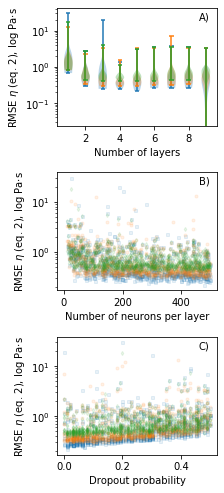

In [4]:
plt.figure(figsize=(3.22,7))

plt.subplot(3,1,1)
plt.violinplot([record_loss.loc[record_loss["nb_layers"]==i,"loss_ag_train"].values for i in range(1,10)],
               [i for i in range(1,10)])

plt.violinplot([record_loss.loc[record_loss["nb_layers"]==i,"loss_ag_valid"].values for i in range(1,10)],
               [i for i in range(1,10)])

plt.violinplot([record_loss.loc[record_loss["nb_layers"]==i,"loss_ag_test"].values for i in range(1,10)],
               [i for i in range(1,10)])

plt.yscale('log')
#plt.ylim(0.01,10000)

plt.xlabel("Number of layers")
plt.ylabel("RMSE $\eta$ (eq. 2), log Pa$\cdot$s")
plt.annotate("A)",xy=(0.95,0.9),xycoords="axes fraction",ha="right")

plt.subplot(3,1,2)
plt.plot(record_loss.loc[:,"nb_neurons"],record_loss.loc[:,"loss_ag_train"],"s",alpha=0.1,markersize=3,color="C0")
plt.plot(record_loss.loc[:,"nb_neurons"],record_loss.loc[:,"loss_ag_valid"],"o",alpha=0.1,markersize=3,color="C1")
plt.plot(record_loss.loc[:,"nb_neurons"],record_loss.loc[:,"loss_ag_test"],"d",alpha=0.1,markersize=3,color="C2")
plt.yscale('log')

#plt.ylim(0.01,10000)

plt.xlabel("Number of neurons per layer")
plt.ylabel("RMSE $\eta$ (eq. 2), log Pa$\cdot$s")
           
plt.annotate("B)",xy=(0.95,0.9),xycoords="axes fraction",ha="right")

plt.subplot(3,1,3)
plt.plot(record_loss.loc[:,"p_drop"],record_loss.loc[:,"loss_ag_train"],"s",color="C0",alpha=0.1,markersize=3,label="Train")
plt.plot(record_loss.loc[:,"p_drop"],record_loss.loc[:,"loss_ag_valid"],"o",color="C1",alpha=0.1,markersize=3,label="Valid")
plt.plot(record_loss.loc[:,"p_drop"],record_loss.loc[:,"loss_ag_test"],"d",color="C2",alpha=0.1,markersize=3,label="Test")
plt.yscale('log')

#plt.ylim(0.01,10000)

plt.annotate("C)",xy=(0.95,0.9),xycoords="axes fraction",ha="right")

plt.xlabel("Dropout probability")
plt.ylabel("RMSE $\eta$ (eq. 2), log Pa$\cdot$s")

plt.tight_layout()
plt.savefig("./figures/SupplementaryFigure2.pdf")

# Detect best models

For that we use the global "loss_valid" = loss_viscosiuty + loss_raman + loss_density + loss_refractiveindex

In [96]:
best_recorded = record_loss.nsmallest(10,"loss_valid")
best_recorded

,name,nb_layers,nb_neurons,p_drop,loss_ag_train,loss_ag_valid,loss_ag_test,loss_am_train,loss_am_valid,loss_am_test,...,loss_raman_train,loss_raman_valid,loss_valid,loss_test,loss_myega_train,loss_ri_train,loss_myega_valid,loss_ri_valid,loss_myega_test,loss_ri_test
1696,l7_n405_p0.0.pth,7.0,405.0,0.00,0.264369,0.355148,0.485036,0.245110,0.358688,0.465636,...,0.078323,0.079126,1.366053,0.0,0.244942,0.003446,0.383286,0.003803,0.477114,0.004406
1932,l8_n103_p0.0.pth,8.0,103.0,0.00,0.296501,0.313550,0.489652,0.291275,0.375767,0.522358,...,0.072740,0.080544,1.398158,0.0,0.281065,0.003684,0.392404,0.004059,0.513874,0.004498
592,l9_n230_p0.0.pth,9.0,230.0,0.00,0.338181,0.437578,0.520899,0.302693,0.447805,0.509068,...,0.083983,0.084273,1.406593,0.0,0.299412,0.004010,0.469753,0.004789,0.513369,0.005580
108,l4_n309_p0.01.pth,4.0,309.0,0.01,0.251450,0.337659,0.463210,0.239733,0.376069,0.465155,...,0.067154,0.069045,1.426519,0.0,0.244260,0.003358,0.401850,0.003839,0.468572,0.004249
1279,l8_n211_p0.01.pth,8.0,211.0,0.01,0.392229,0.364398,0.469820,0.423178,0.420162,0.485339,...,0.083253,0.084566,1.428429,0.0,0.411975,0.004572,0.440539,0.005451,0.462240,0.005818
475,l3_n493_p0.01.pth,3.0,493.0,0.01,0.245454,0.320802,0.483248,0.238925,0.384140,0.489126,...,0.060202,0.067044,1.428443,0.0,0.241140,0.003242,0.404201,0.002985,0.488932,0.005329
1248,l3_n266_p0.0.pth,3.0,266.0,0.00,0.224995,0.346582,0.530951,0.220564,0.409771,0.538891,...,0.057775,0.066913,1.447791,0.0,0.220932,0.003091,0.397834,0.003098,0.532208,0.004673
91,l3_n365_p0.05.pth,3.0,365.0,0.05,0.311933,0.328855,0.487678,0.314427,0.373121,0.495743,...,0.070614,0.074949,1.451670,0.0,0.325984,0.003363,0.426786,0.003469,0.500190,0.005234
1259,l3_n275_p0.02.pth,3.0,275.0,0.02,0.278857,0.310380,0.452428,0.273400,0.348187,0.452268,...,0.066323,0.077940,1.460880,0.0,0.287343,0.003337,0.390342,0.003678,0.460164,0.004638
1542,l7_n221_p0.0.pth,7.0,221.0,0.00,0.282840,0.374159,0.456612,0.260209,0.381421,0.436280,...,0.081551,0.083142,1.462510,0.0,0.261963,0.003328,0.399960,0.003247,0.443040,0.004596


In [98]:
# importing shutil module  
import shutil 

# Copy the content of 
# source to destination 
for i in best_recorded.loc[:,"name"]:
    shutil.copyfile("./model/exp_arch/"+i, "./model/best/"+i) 

best_recorded.to_csv("./model/best/best_list.csv")